In [1]:
# Core libs
import os
import json
import pandas as pd
import numpy as np

# Modeling & evaluation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix
)

# Persistence & plotting
import joblib
import matplotlib.pyplot as plt

# Paths (relative to this notebook in notebooks/)
TRAIN_PATH = "../data/processed/drugsComTrain_clean_labeled.tsv"
TEST_PATH  = "../data/processed/drugsComTest_clean_labeled.tsv"

# Output locations
ARTIF_DIR   = "../artifacts/tfidf_baseline"
FIG_DIR     = "../reports/figures"
os.makedirs(ARTIF_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

SEED = 42  # reproducibility
np.random.seed(SEED)


In [2]:
# Read TSVs with cleaned text and binary labels
df_train = pd.read_csv(TRAIN_PATH, sep="\t")
df_test  = pd.read_csv(TEST_PATH,  sep="\t")

print(f"Train shape: {df_train.shape[0]:,} rows × {df_train.shape[1]} columns")
print(f"Test shape : {df_test.shape[0]:,} rows × {df_test.shape[1]} columns")

# Sanity: required columns
required = {"review_clean", "label_bin"}
missing_train = required - set(df_train.columns)
missing_test  = required - set(df_test.columns)
assert not missing_train and not missing_test, (missing_train, missing_test)


Train shape: 161,297 rows × 8 columns
Test shape : 53,766 rows × 8 columns


In [3]:
def drop_bad_rows(df):
    # Drop rows where text or label is missing
    df = df.dropna(subset=["review_clean", "label_bin"]).copy()
    # Remove rows where cleaned text is empty after stripping
    df = df[df["review_clean"].str.strip().str.len() > 0]
    # Ensure label is int (0/1)
    df["label_bin"] = df["label_bin"].astype(int)
    return df

df_train = drop_bad_rows(df_train)
df_test  = drop_bad_rows(df_test)

print(f"After filtering → Train: {len(df_train):,} | Test: {len(df_test):,}")
print("Class balance (train):")
print(df_train["label_bin"].value_counts(normalize=True).sort_index().rename({0:"neg",1:"pos"}).map(lambda x: f"{x*100:.1f}%"))
print("Class balance (test):")
print(df_test["label_bin"].value_counts(normalize=True).sort_index().rename({0:"neg",1:"pos"}).map(lambda x: f"{x*100:.1f}%"))


After filtering → Train: 161,297 | Test: 53,766
Class balance (train):
label_bin
neg    39.6%
pos    60.4%
Name: proportion, dtype: object
Class balance (test):
label_bin
neg    39.8%
pos    60.2%
Name: proportion, dtype: object


In [4]:
# Vectorizer settings: unigrams + bigrams; drop ultra-rare terms; cap vocab
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),      # unigrams + bigrams
    min_df=5,                # ignore terms in <5 docs
    max_features=200_000,    # vocab cap
    sublinear_tf=True,       # log(1+tf)
    use_idf=True, smooth_idf=True,
    norm="l2",
    lowercase=True
)

# Fit on TRAIN text only, then transform train and test
X_train = vectorizer.fit_transform(df_train["review_clean"].values)
X_test  = vectorizer.transform(df_test["review_clean"].values)

y_train = df_train["label_bin"].values
y_test  = df_test["label_bin"].values

print(f"X_train shape: {X_train.shape} | X_test shape: {X_test.shape}")


X_train shape: (161297, 200000) | X_test shape: (53766, 200000)


In [5]:
# train logisitic regression classifier
clf = LogisticRegression(
    penalty="l2",
    solver="liblinear",   # solid for smaller/sparse problems
    C=1.0,
    class_weight="balanced",  # compensate class imbalance
    max_iter=1000,
    random_state=SEED
)
clf.fit(X_train, y_train)

print("Training complete.")


Training complete.


In [ ]:
# Predictions & probabilities
y_pred = clf.predict(X_test)

# Metrics
acc = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")
f1_pos = f1_score(y_test, y_pred, pos_label=1)
f1_neg = f1_score(y_test, y_pred, pos_label=0)

print(f"Accuracy : {acc:.4f}")
print(f"Macro-F1 : {macro_f1:.4f}")
print(f"F1 (neg) : {f1_neg:.4f}")
print(f"F1 (pos) : {f1_pos:.4f}")


print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=4))


Accuracy : 0.8642
Macro-F1 : 0.8597
F1 (neg) : 0.8343
F1 (pos) : 0.8850

Classification report:
              precision    recall  f1-score   support

           0     0.8117    0.8583    0.8343     21417
           1     0.9025    0.8682    0.8850     32349

    accuracy                         0.8642     53766
   macro avg     0.8571    0.8632    0.8597     53766
weighted avg     0.8663    0.8642    0.8648     53766



In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(cm, interpolation="nearest")
ax.set_title("TF-IDF + LR — Confusion Matrix")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
ax.set_xticklabels(["0 (neg)", "1 (pos)"])
ax.set_yticklabels(["0 (neg)", "1 (pos)"])

# annotate counts
for (i, j), v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha="center", va="center")

plt.tight_layout()
out_fig = os.path.join(FIG_DIR, "tfidf_confusion_matrix.png")
plt.savefig(out_fig, dpi=150)
plt.show()

print(f"Saved confusion matrix → {out_fig}")


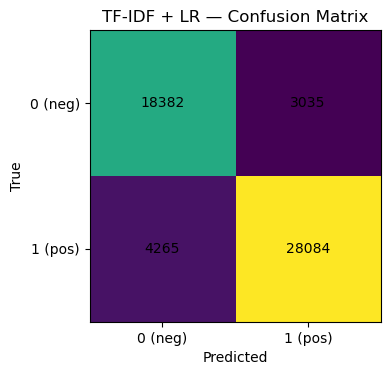

Saved confusion matrix → ../reports/figures/tfidf_confusion_matrix.png


In [7]:
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(cm, interpolation="nearest")
ax.set_title("TF-IDF + LR — Confusion Matrix")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
ax.set_xticklabels(["0 (neg)", "1 (pos)"])
ax.set_yticklabels(["0 (neg)", "1 (pos)"])

# annotate counts
for (i, j), v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha="center", va="center")

plt.tight_layout()
out_fig = os.path.join(FIG_DIR, "tfidf_confusion_matrix.png")
plt.savefig(out_fig, dpi=150)
plt.show()

print(f"Saved confusion matrix → {out_fig}")


In [9]:
metrics = {
    "accuracy": float(acc),
    "macro_f1": float(macro_f1),
    "f1_neg": float(f1_neg),
    "f1_pos": float(f1_pos),
    "n_train": int(X_train.shape[0]),
    "n_test": int(X_test.shape[0]),
    "vocab_size": int(len(vectorizer.vocabulary_))
}

out_metrics = os.path.join(ARTIF_DIR, "metrics.json")
with open(out_metrics, "w") as f:
    json.dump(metrics, f, indent=2)

print(f"Saved metrics → {out_metrics}")
metrics

Saved metrics → ../artifacts/tfidf_baseline/metrics.json


{'accuracy': 0.8642264628203697,
 'macro_f1': 0.8596566444270615,
 'f1_neg': 0.8343318809005084,
 'f1_pos': 0.8849814079536145,
 'n_train': 161297,
 'n_test': 53766,
 'vocab_size': 200000}

In [10]:
vec_path = os.path.join(ARTIF_DIR, "vectorizer.joblib")
mdl_path = os.path.join(ARTIF_DIR, "model.joblib")

joblib.dump(vectorizer, vec_path)
joblib.dump(clf, mdl_path)

print("Saved artifacts:")
print(f" - {vec_path}")
print(f" - {mdl_path}")


Saved artifacts:
 - ../artifacts/tfidf_baseline/vectorizer.joblib
 - ../artifacts/tfidf_baseline/model.joblib


In [11]:
# Examine which tokens push predictions toward pos/neg
# (only for curiosity and debugging —)
feature_names = np.array(vectorizer.get_feature_names_out())
coefs = clf.coef_.ravel()  # 1D array; positive -> class 1, negative -> class 0

top_pos_idx = np.argsort(coefs)[-20:][::-1]
top_neg_idx = np.argsort(coefs)[:20]

print("Top positive terms:")
print(feature_names[top_pos_idx])

print("\nTop negative terms:")
print(feature_names[top_neg_idx])


Top positive terms:
['love' 'amazing' 'miracle' 'best' 'great' 'love it' 'wonderful'
 'love this' 'years' 'no side' 'works' 'life' 'saved' 'excellent' 'gone'
 'highly recommend' 'the only' 'happy' 'awesome' 'highly']

Top negative terms:
['worse' 'not recommend' 'not worth' 'not' 'gained' 'worst' 'horrible'
 'disappointed' 'no relief' 'depressed' 'terrible' 'it removed'
 'nothing for' 'switching' 'hoping' 'this' 'bleeding' 'the side'
 'never again' 'removed']
